In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")

In [ ]:
directory = "Processed Images_Fruits"
label = os.listdir(directory)
fruit = [os.listdir(f"{directory}/{label[i]}") for i in range (3)]
files = list(map(lambda x,y : [[f"{directory}/{label[y]}/{i}/{j}" for j in os.listdir(f"{directory}/{label[y]}/{i}")] for i in x],[os.listdir(f"{directory}/{label[i]}") for i in range (3)],range(3)))
file_dic = {i[c]:j[c] for i,j in zip(fruit,files) for c in range(6)}
for i in file_dic.copy().keys():
    if "_" not in i:
        file_dic[f"{i}_Mixed"] = file_dic.pop(i)
label_2 = list(file_dic.keys())
df = pd.DataFrame(dict(zip(["filepaths","labels"],[[j for i in label_2 for j in file_dic[i]],[i for i in label_2 for j in file_dic[i]]])))
#데이터를 불러와서 데이터프레임에 저장

In [ ]:
# 데이터 프레임을 훈련/검증/테스트 셋으로 분할
trsplit=.9
vsplit=.05
dsplit =vsplit/(1-trsplit)
strat=df['labels']
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=42, stratify=strat)
strat=dummy_df['labels']
test_df, valid_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=42, stratify=strat)
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
classes=list(train_df['labels'].unique())
class_count = len(classes)
groups=df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)
      samples=len(group)
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
#클래스 불균형이 있는지 확인하기 위하여 각 클래스별 빈도를 카운트

train_df lenght:  17573   test_df length:  976   valid_df length:  977
            CLASS               IMAGE COUNT 
           Lime_Bad                1085     
          Guava_Good               1152     
         Orange_Good               1216     
          Banana_Bad               1087     
       Pomegranate_Bad             1187     
       Pomegranate_Good            5940     
          Orange_Bad               1159     
          Apple_Bad                1141     
         Guava_Mixed                148     
          Apple_Good               1149     
         Banana_Good               1113     
         Banana_Mixed               285     
          Guava_Bad                1129     
         Orange_Mixed               125     
      Pomegranate_Mixed             125     
         Apple_Mixed                113     
          Lime_Good                1094     
         Lemon_Mixed                278     


In [ ]:
train_df

,filepaths,labels
14630,Processed Images_Fruits/Bad Quality_Fruits/Lim...,Lime_Bad
631,Processed Images_Fruits/Good Quality_Fruits/Gu...,Guava_Good
10505,Processed Images_Fruits/Good Quality_Fruits/Or...,Orange_Good
12193,Processed Images_Fruits/Bad Quality_Fruits/Ban...,Banana_Bad
18425,Processed Images_Fruits/Bad Quality_Fruits/Pom...,Pomegranate_Bad
...,...,...
6009,Processed Images_Fruits/Good Quality_Fruits/Po...,Pomegranate_Good
10908,Processed Images_Fruits/Good Quality_Fruits/Or...,Orange_Good
1197,Processed Images_Fruits/Good Quality_Fruits/Ap...,Apple_Good
1883,Processed Images_Fruits/Good Quality_Fruits/Ap...,Apple_Good


In [ ]:
def trim (df, max_size, min_size, column): #빈도수가 많은 클래스의 데이터를 버리고, 클래스 수를 맞춰주기 위한 트리밍
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=42, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [ ]:
max_samples=500
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)

Original Number of classes in dataframe:  18
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 256, 250, 133, 113, 113, 102]


In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size): # 클래스 수를 맞춰주기 위한 이미지 증강 과정
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column) 
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # 증강 데이터를 저장하기 위한 aug_dir/labels 폴더생성
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') 
    for label in train_df['labels'].unique():                
        group=groups.get_group(label) 
        sample_count=len(group)  
        if sample_count< max_samples: # 해당 클래스의 수가 max_sample보다 작으면 데이터 생성
            aug_img_count=0
            delta=max_samples-sample_count  
            target_dir=os.path.join(aug_dir, label)      
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

In [ ]:
working_dir=r'/content/drive/MyDrive/Colab Notebooks'
img_size=(224,224)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  18
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 256, 250, 133, 113, 113, 102]
Found 133 validated image filenames.
Found 256 validated image filenames.
Found 113 validated image filenames.
Found 113 validated image filenames.
Found 102 validated image filenames.
Found 250 validated image filenames.
Total Augmented images created=  2033
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


In [ ]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 ,rescale =  1./255)
t_and_v_gen=ImageDataGenerator(rescale =  1./255) #데이터는 1/255로 정규화
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 9000 validated image filenames belonging to 18 classes.
Found 977 validated image filenames belonging to 18 classes.
Found 976 validated image filenames belonging to 18 classes.
test batch size:  61   test steps:  16  number of classes :  18
       class name        class index 
        Apple_Bad             0      
       Apple_Good             1      
       Apple_Mixed            2      
       Banana_Bad             3      
       Banana_Good            4      
      Banana_Mixed            5      
        Guava_Bad             6      
       Guava_Good             7      
       Guava_Mixed            8      
       Lemon_Mixed            9      
        Lime_Bad              10     
        Lime_Good             11     
       Orange_Bad             12     
       Orange_Good            13     
      Orange_Mixed            14     
     Pomegranate_Bad          15     
    Pomegranate_Good          16     
    Pomegranate_Mixed         17     


In [ ]:
images,labels=next(train_gen)

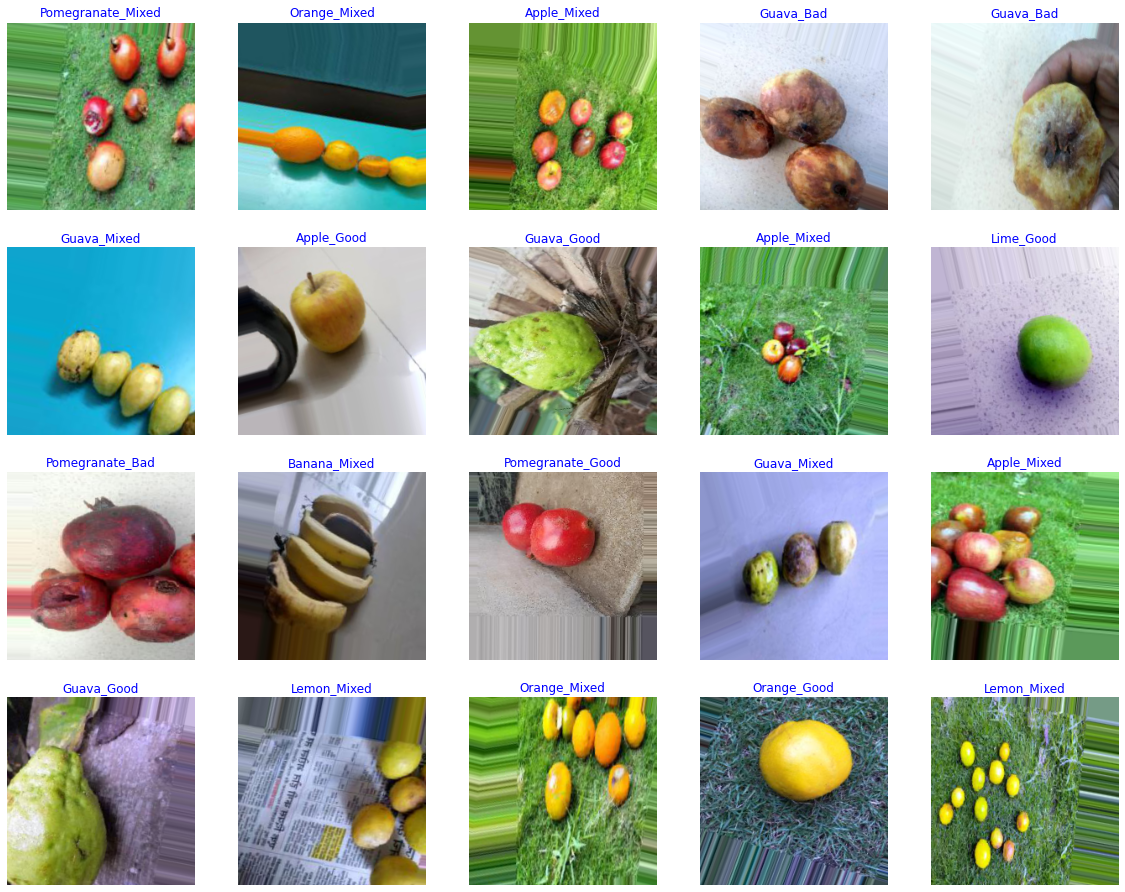

In [ ]:
def show_image_samples(gen ): #증강 이미지 일부 출력
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i]  
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

In [ ]:
pip install -U keras-efficientnet-v2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras_efficientnet_v2

In [125]:
img_shape=(224, 224, 3)
model_name='EfficientNetV2S'
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=True #사전모델의 가중치를 훈련 가능하게 설정. 이는 각 등급의 과일 이미지를 가중치에 충분히 학습시키기 위함임
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1280, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=42)(x)
x = Dense(128,activation='ELU')(x)
x=Dropout(rate=.45, seed=42)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [126]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_6[0][0]']            
                                )                                                                 
                                                                                            

In [121]:
class ASK(keras.callbacks.Callback): # 훈련을 더 진행할건지 묻고, 시간을 나타내주는 콜백
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [128]:
epochs=40
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [127]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
450/450 [==============================] - 223s 443ms/step - loss: 11.1932 - accuracy: 0.7723 - val_loss: 7.0483 - val_accuracy: 0.9601 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 198s 439ms/step - loss: 5.5154 - accuracy: 0.8997 - val_loss: 3.5656 - val_accuracy: 0.9765 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 194s 431ms/step - loss: 2.8324 - accuracy: 0.9263 - val_loss: 1.8814 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 195s 432ms/step - loss: 1.4770 - accuracy: 0.9510 - val_loss: 1.6505 - val_accuracy: 0.9478 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 192s 427ms/step - loss: 0.7498 - accuracy: 0.9722 - val_loss: 0.6018 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 6/40
450/450 [=======================

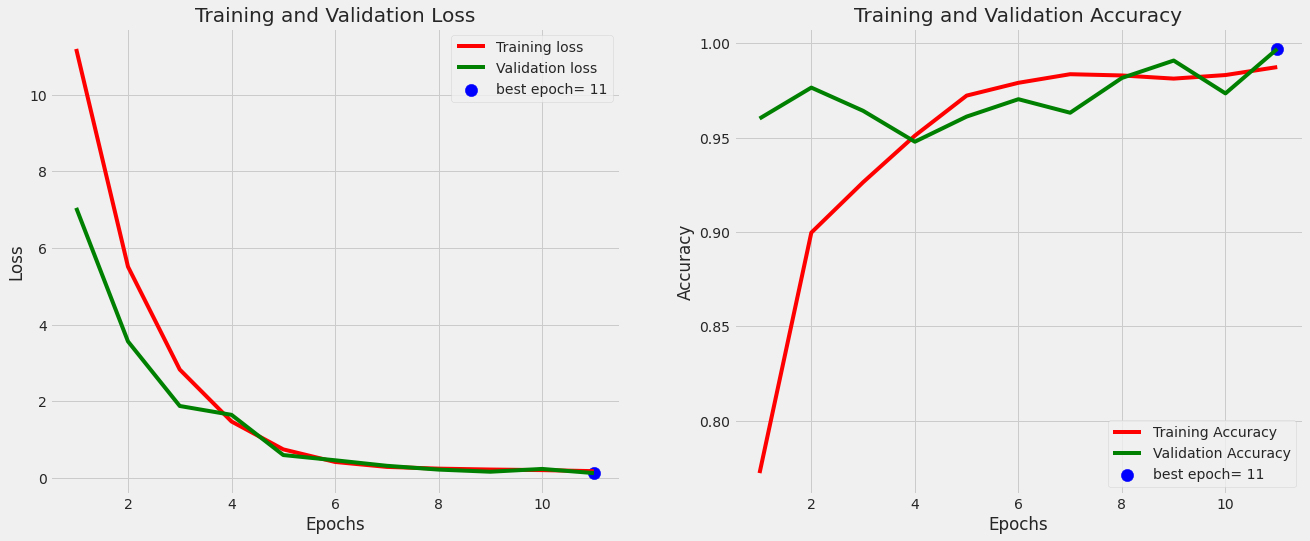

In [156]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout   
    plt.savefig(f'{i}.png', transparent = True) 
    plt.show()
    
tr_plot(history,0)

16/16 [==============================] - 16s 910ms/step
there were 3 in 976 tests for an accuracy of  99.69


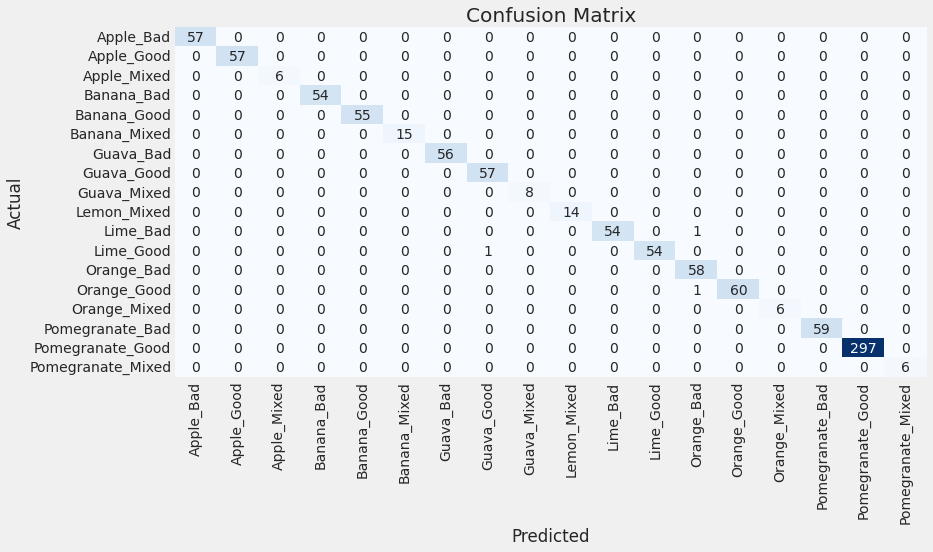

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     1.0000    1.0000    1.0000        57
       Apple_Good     1.0000    1.0000    1.0000        57
      Apple_Mixed     1.0000    1.0000    1.0000         6
       Banana_Bad     1.0000    1.0000    1.0000        54
      Banana_Good     1.0000    1.0000    1.0000        55
     Banana_Mixed     1.0000    1.0000    1.0000        15
        Guava_Bad     1.0000    1.0000    1.0000        56
       Guava_Good     0.9828    1.0000    0.9913        57
      Guava_Mixed     1.0000    1.0000    1.0000         8
      Lemon_Mixed     1.0000    1.0000    1.0000        14
         Lime_Bad     1.0000    0.9818    0.9908        55
        Lime_Good     1.0000    0.9818    0.9908        55
       Orange_Bad     0.9667    1.0000    0.9831        58
      Orange_Good     1.0000    0.9836    0.9917        61
     Orange_Mixed     1.0000    1.0000    1.0000         6
  Pomegr

In [157]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('confusion.png', transparent = True) 
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

In [139]:
subject='Indian Fruit' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

model was saved as  /content/drive/MyDrive/Colab Notebooks/Indian Fruit_99.69.h5


In [132]:
my_pic = ["KakaoTalk_banana.jpg","KakaoTalk_apple_01.jpg","KakaoTalk_apple_02.jpg"]

In [140]:
from keras.preprocessing.image import load_img, img_to_array
def img_pred(name, model):
    image = load_img(name,target_size=(224,224))
    input_arr = img_to_array(image) / 255.
        
    input_arr = np.array([input_arr]).astype('float32')
    predictions = model.predict(input_arr)
    predict_class = np.argmax(predictions, axis=1) 

    return predict_class[0],input_arr

In [151]:
pred_arr = [img_pred(i,model) for i in my_pic]

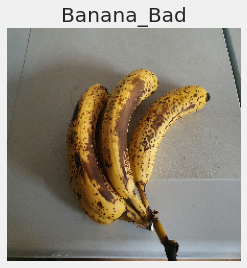

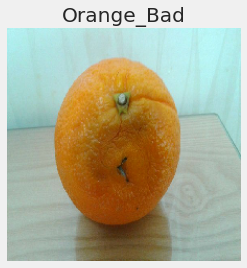

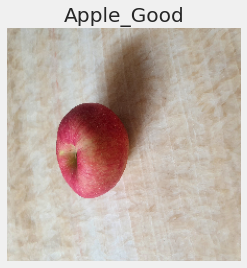

In [159]:
for i in pred_arr:
  plt.title(classes[i[0]])
  plt.imshow(tf.keras.preprocessing.image.array_to_img(i[1][0]))
  plt.axis('off')
  plt.savefig(f'{classes[i[0]]}.png', transparent = True) 
  plt.show()